# Ковидын эерэг болон сөрөг 2 ангилалын загвар

## Сангуудаа импортлох

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from keras import layers, models
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, LeakyReLU, BatchNormalization, MaxPooling1D, Dropout
from keras.utils import to_categorical

## Өгөгдлөө унших

In [16]:
dataset = pd.read_csv('../../input/augmented_data/spectrum.csv', low_memory=False)

In [17]:
display(dataset.head().T, dataset.shape)

,0,1,2,3,4
320,23.767617,6.554332,-65.876227,-3.539452,-32.211329
321,8.541673,-3.982771,-52.107447,-25.36141,3.569451
322,-6.737708,-12.508809,-43.797257,-22.890028,-25.360113
323,-13.844851,-14.161707,-34.973131,-15.633461,-24.382165
324,-15.338898,-11.528857,-24.758405,-24.196508,-13.837212
...,...,...,...,...,...
classfication,0,0,0,0,0
negpos,0,0,0,0,0
medium,NaN,NaN,NaN,NaN,NaN
mediumclassification,NaN,NaN,NaN,NaN,NaN


(6400, 1338)

## Өгөгдлөө бэлдэх

In [18]:
def preprocess_data(dataset):
    labels = dataset.columns[-7:]
    dataset = dataset[dataset['covid_status'] == 'positive']
    X = dataset.drop(labels, axis=1)
    X.columns = X.columns.astype(int)
    y = dataset['classfication']

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    y = to_categorical(y, num_classes=3)

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

    return X_train, X_test, y_train, y_test

In [19]:
X_train, X_test, y_train, y_test = preprocess_data(dataset)

In [20]:
y_train.shape, y_test.shape

((3825, 3), (1275, 3))

In [21]:
NUM_EPOCHS = 50

In [28]:
def simple_cnn(X_train, X_test, y_train, y_test, num_epochs=NUM_EPOCHS):

    model = Sequential([
        Conv1D(16, 21, input_shape=(X_train.shape[1], 1)),
        BatchNormalization(),
        LeakyReLU(0.01),
        MaxPooling1D(16),

        Conv1D(32, 11),
        BatchNormalization(),
        LeakyReLU(0.01),
        MaxPooling1D(8),

        Conv1D(64, 5),
        BatchNormalization(),
        LeakyReLU(0.01),
        MaxPooling1D(4),
        
        Flatten(),
        BatchNormalization(),

        Dense(2048, activation='tanh'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(3, activation='softmax')
    ])

    optimizer = Adam(learning_rate=0.0002)

    model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []
    for i in range(num_epochs):
        history = model.fit(X_train, y_train, epochs=1, batch_size=8, verbose=0)
        
        train_loss.append(history.history['loss'][0])
        train_accuracy.append(history.history['accuracy'][0])

        loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

        test_loss.append(loss)
        test_accuracy.append(accuracy)
        if (i + 1) % 5 == 0:
            print(f'Epoch {i+1} => Test Loss: {loss:.2f} - Test Accuracy: {accuracy*100:.2f}%')

    # fig, axs = plt.subplots(ncols=2)
    # axs[0].plot(train_accuracy, label='train_accuracy')
    # axs[0].plot(test_accuracy, label='test_accuracy')
    # axs[0].title('Model accuracy')
    # axs[0].xlabel('Epoch')
    # axs[0].ylabel('Accuracy')

    # axs[1].plot(train_loss, label='train_loss')
    # axs[1].plot(test_loss, label='test_loss')
    # axs[1].title('Model loss')
    # axs[1].xlabel('Epoch')
    # axs[1].ylabel('Loss')

    # plt.tight_layout()
    # plt.show()

    return model

In [29]:
lenet_model = simple_cnn(X_train, X_test, y_train, y_test)

Epoch 5 => Test Loss: 0.17 - Test Accuracy: 93.10%
Epoch 10 => Test Loss: 0.12 - Test Accuracy: 94.51%
Epoch 15 => Test Loss: 0.11 - Test Accuracy: 93.57%
Epoch 20 => Test Loss: 0.14 - Test Accuracy: 94.12%
Epoch 25 => Test Loss: 0.16 - Test Accuracy: 92.71%
Epoch 30 => Test Loss: 0.16 - Test Accuracy: 93.18%
Epoch 35 => Test Loss: 0.21 - Test Accuracy: 93.33%
Epoch 40 => Test Loss: 0.18 - Test Accuracy: 93.18%
Epoch 45 => Test Loss: 0.21 - Test Accuracy: 93.25%
Epoch 50 => Test Loss: 0.22 - Test Accuracy: 93.88%


In [30]:
y_pred = lenet_model.predict(X_test)
print(np.unique(np.argmax(y_test, axis=1)), np.unique(np.argmax(y_pred, axis=1)))

40/40 [==============================] - 0s 3ms/step
[0 1 2] [0 1 2]


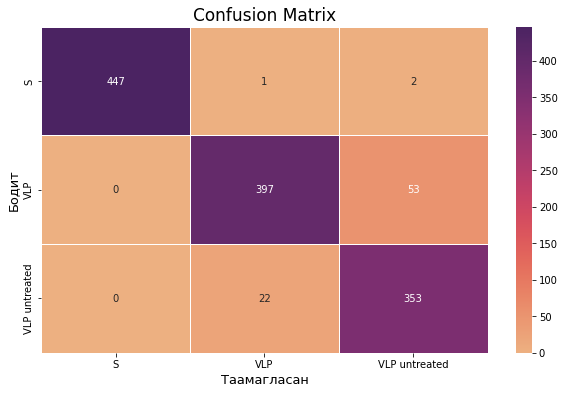

In [31]:
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

category_labels = ['S', 'VLP', 'VLP untreated']
fig, ax = plt.subplots(figsize=(10, 6)) 
sns.heatmap(cm, 
            ax=ax,
            annot=True,
            cmap="flare",
            linewidth=.5,
            fmt='g', 
            xticklabels=category_labels,
            yticklabels=category_labels)
plt.xlabel('Таамагласан',fontsize=13)
plt.ylabel('Бодит',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()